# WSDM - KKBox's Churn Prediction Challenge 

#### I) Loading and first preparation of the data

    1) Pipeline
    2) Loading Data
    3) Preparing Data for the Exploration Data Analysis

#### II) Exploration data analysis

    1) Demographical analysis
    2) Exploring the most important features
    3) Correlation between the important features
    
#### III) Feature Engineering and Data Cleaning

    1) Adding of new features
    2) Filling missing values
    3) Removing Useless Features
    
#### IV) Predictive Modeling

    1) K-Folds
    2) Random Forest
    3) XGBoost
    4) Stacking & Creation of submission files




# I) Loading and first preparation of the data

## I.1) Pipeline

In [3]:
from multiprocessing import Pool, cpu_count
import gc; gc.enable()
import xgboost as xgb
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn import *
import sklearn
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

/Users/antoinedandigne/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/antoinedandigne/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/antoinedandigne/anaconda/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed 

##  I.2) Loading data

In [ ]:
train = pd.read_csv('./data_KKbox/train.csv')
train = pd.concat((train, pd.read_csv('./data_KKbox/train_v2.csv')), axis=0, ignore_index=True).reset_index(drop=True)
test = pd.read_csv('./data_KKbox/sample_submission_v2.csv')

### Adding the transaction count per user

In [ ]:
transactions = pd.read_csv('./data_KKbox/transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv('./data_KKbox/transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','trans_count']
train = pd.merge(train, transactions, how='left', on='msno')
test = pd.merge(test, transactions, how='left', on='msno')
transactions = []; print('transaction merge...')

### Adding the logs count per user

In [6]:
user_logs = pd.read_csv('./data_KKbox/user_logs_v2.csv', usecols=['msno'])
user_logs = pd.DataFrame(user_logs['msno'].value_counts().reset_index())
user_logs.columns = ['msno','logs_count']
train = pd.merge(train, user_logs, how='left', on='msno')
test = pd.merge(test, user_logs, how='left', on='msno')
user_logs = []; print('user logs merge...')

user logs merge...


### Adding members' information

In [7]:
members = pd.read_csv('./data_KKbox/members_v3.csv')
train = pd.merge(train, members, how='left', on='msno')
test = pd.merge(test, members, how='left', on='msno')
members = []; print('members merge...') 

members merge...


### Adding last transaction date per user

In [8]:
transactions = pd.read_csv('./data_KKbox/transactions.csv')
transactions = pd.concat((transactions, pd.read_csv('./data_KKbox/transactions_v2.csv')), axis=0, ignore_index=True).reset_index(drop=True)
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')

train = pd.merge(train, transactions, how='left', on='msno')
test = pd.merge(test, transactions, how='left', on='msno')
transactions=[]

### Adding information from user_logs

In [9]:
def transform_df(df):
    df = pd.DataFrame(df)
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

def transform_df2(df):
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

df_iter = pd.read_csv('./data_KKbox/user_logs.csv', low_memory=False, iterator=True, chunksize=10000000)
last_user_logs = []
i = 0 #~400 Million Records - starting at the end but remove locally if needed
for df in df_iter:
    if i>35:
        if len(df)>0:
            print(df.shape)
            p = Pool(cpu_count())
            df = p.map(transform_df, np.array_split(df, cpu_count()))   
            df = pd.concat(df, axis=0, ignore_index=True).reset_index(drop=True)
            df = transform_df2(df)
            p.close(); p.join()
            last_user_logs.append(df)
            print('...', df.shape)
            df = []
    i+=1
last_user_logs.append(transform_df(pd.read_csv('./data_KKbox/user_logs_v2.csv')))
last_user_logs = pd.concat(last_user_logs, axis=0, ignore_index=True).reset_index(drop=True)
last_user_logs = transform_df2(last_user_logs)

train = pd.merge(train, last_user_logs, how='left', on='msno')
test = pd.merge(test, last_user_logs, how='left', on='msno')
last_user_logs=[]

(10000000, 9)
... (1616917, 9)
(10000000, 9)
... (1533539, 9)
(10000000, 9)
... (1353720, 9)
(2106543, 9)
... (429234, 9)


## I.3) Preparing data for the Exploration Data Analysis

### Gender Feature

In [10]:
gender = {'male':1, 'female':2}
train['gender'] = train['gender'].map(gender)
test['gender'] = test['gender'].map(gender)

train = train.fillna(0)
test = test.fillna(0)

### Filling missing values

In [13]:
train = train.fillna(0)
test = test.fillna(0)

cols = [c for c in train.columns if c not in ['is_churn','msno']]

# II) Exploration Data Analysis

In [134]:
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963891 entries, 0 to 1963890
Data columns (total 25 columns):
msno                      object
is_churn                  int64
trans_count               int64
logs_count                float64
city                      float64
bd                        float64
registration_init_time    float64
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
date                      float64
num_25                    float64
num_50                    float64
num_75                    float64
num_985                   float64
num_100                   float64
num_unq                   float64
total_secs                float64
discount                  int64
autorenew_&_not_cancel    int8
notAutorenew_&_cancel     int8
dtypes: float64(12), int64(10), int8(2), object(1)
memory usage:

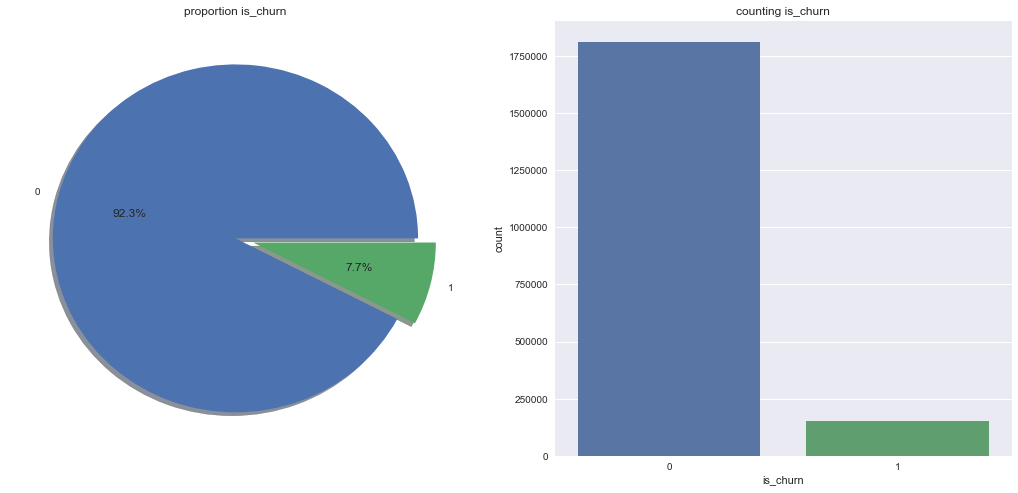

In [15]:
#ploting is_churn
f,ax=plt.subplots(1,2,figsize=(18,8))
train['is_churn'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('proportion is_churn')
ax[0].set_ylabel('')
sns.countplot('is_churn',data=train,ax=ax[1])
ax[1].set_title('counting is_churn')
plt.show()

## II.1) Demographical Analysis

### Gender

In [16]:
train.groupby(['gender','is_churn'])['is_churn'].count()

gender  is_churn
0.0     0           1117087
        1             66207
1.0     0            366204
        1             44641
2.0     0            329799
        1             39953
Name: is_churn, dtype: int64

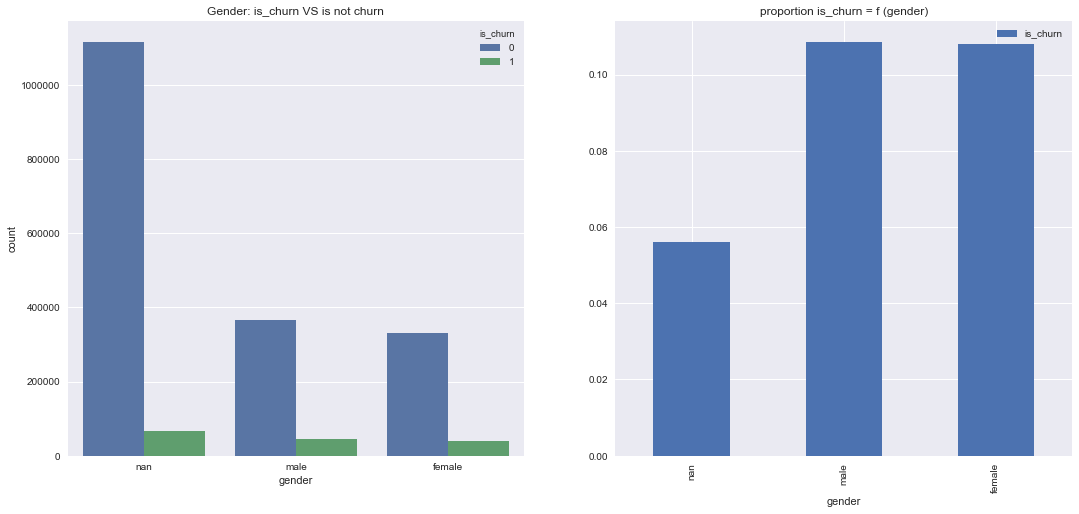

In [17]:
#ploting gender information
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.countplot('gender',hue='is_churn',data=train,ax=ax[0])
ax[0].set_title('Gender: is_churn VS is not churn')
ax[0].set_xticklabels(('nan','male','female'))
train[['gender','is_churn']].groupby(['gender']).mean().plot.bar(ax=ax[1])
ax[1].set_title('proportion is_churn = f (gender)')
ax[1].set_xticklabels(('nan','male','female'))
plt.show()

### Age

In [42]:
train_age = train[train['bd'] >= 10]
train_age = train_age[train_age['bd'] <= 100]

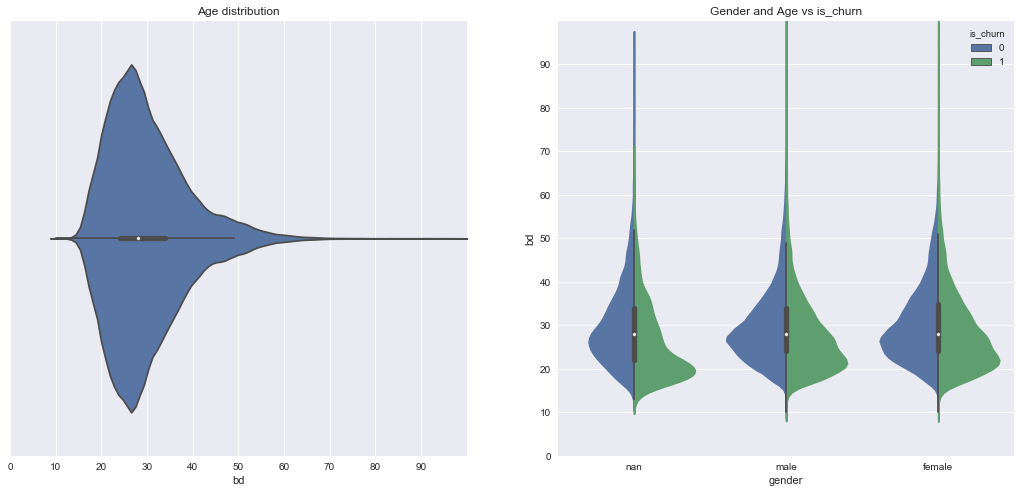

In [41]:
#Ploting age information
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot(x="bd", data=train_age,split=True,ax=ax[0])
ax[0].set_title('Age distribution')
ax[0].set_xticks(range(0,100,10))
ax[0].set_xlim(0, 100)
sns.violinplot("gender","bd", hue="is_churn", data=train_age,split=True,ax=ax[1])
ax[1].set_title('Gender and Age vs is_churn')
ax[1].set_yticks(range(0,100,10))
ax[1].set_ylim(0, 100)
ax[1].set_xticklabels(('nan','male','female'))
plt.show()

### City

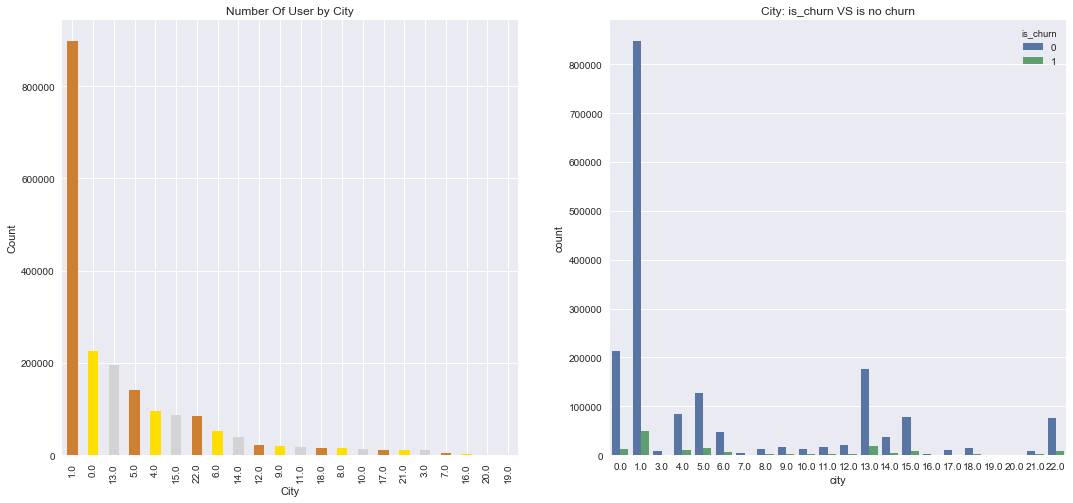

In [20]:
# Ploting the city
f,ax=plt.subplots(1,2,figsize=(18,8))
train['city'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of User by City')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('City')
sns.countplot('city',hue='is_churn',data=train,ax=ax[1])
ax[1].set_title('City: is_churn VS is no churn')
plt.show()

### Registration Via

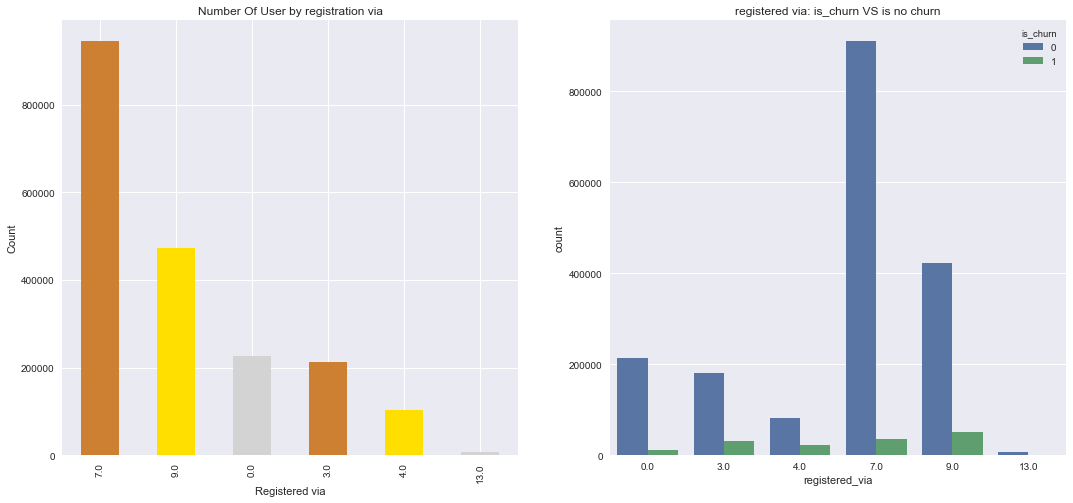

In [21]:
# Ploting the registration via
f,ax=plt.subplots(1,2,figsize=(18,8))
train['registered_via'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of User by registration via')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Registered via')
sns.countplot('registered_via',hue='is_churn',data=train,ax=ax[1])
ax[1].set_title('registered via: is_churn VS is no churn')
plt.show()

## II.2) Exploring the most important features

### Last Transaction Date

In [22]:
LTDate=pd.DataFrame()
LTDate['is_churn']=train['is_churn'].astype(np.int8)
LTDate['transaction_date']= pd.to_datetime(train['transaction_date'],format='%Y%m%d', errors='ignore')
LTDate = LTDate[LTDate['transaction_date'] >= datetime.strptime(str(20170101), '%Y%m%d')]

In [23]:
LTDate=LTDate.groupby(pd.PeriodIndex(LTDate['transaction_date'], period=1, freq='w'))['is_churn'].mean()
LTDate=pd.DataFrame(LTDate)

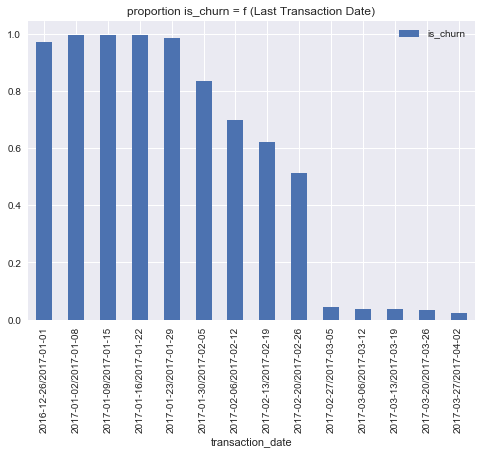

In [24]:
LTDate.plot.bar().set_title('proportion is_churn = f (Last Transaction Date)')
plt.show()

### Membership Expiration Date

In [25]:
MEDate=pd.DataFrame()
MEDate['is_churn']=train['is_churn'].astype(np.int8)
MEDate['membership_expire_date']= pd.to_datetime(train['membership_expire_date'],format='%Y%m%d', errors='ignore')
MEDate = MEDate[MEDate['membership_expire_date'] >= datetime.strptime(str(20170101), '%Y%m%d')]
MEDate = MEDate[MEDate['membership_expire_date'] <= datetime.strptime(str(20170401), '%Y%m%d')]

In [26]:
MEDate=MEDate.groupby(pd.PeriodIndex(MEDate['membership_expire_date'], period=1, freq='w'))['is_churn'].mean()
MEDate=pd.DataFrame(MEDate)

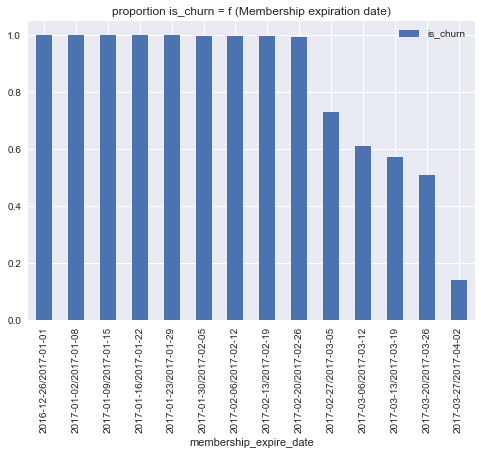

In [27]:
MEDate.plot.bar().set_title('proportion is_churn = f (Membership expiration date)')
plt.show()

### Number of transactions : trans_count

In [73]:
Trans_count=pd.DataFrame()
Trans_count['is_churn']=train['is_churn'].astype(np.int8)
Trans_count['trans_count']=pd.qcut(train['trans_count'],5)
Trans_count.groupby(['trans_count'])['is_churn'].mean().to_frame().style.background_gradient(cmap='summer_r')

,is_churn
trans_count,
"(0.999, 8.0]",0.168462
"(8.0, 15.0]",0.0722701
"(15.0, 20.0]",0.0482765
"(20.0, 27.0]",0.041654
"(27.0, 244.0]",0.0486279


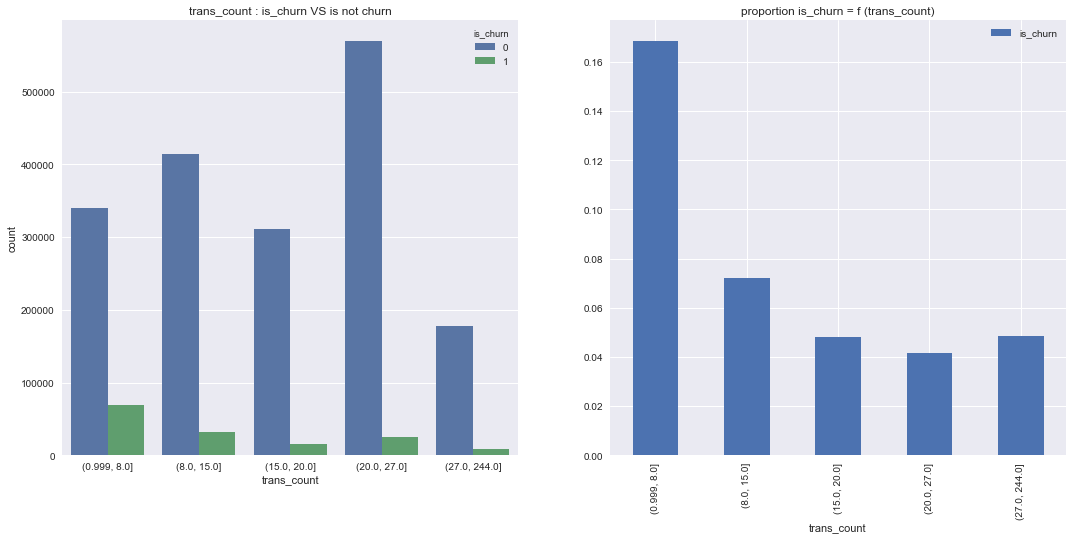

In [75]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.countplot('trans_count',hue='is_churn',data=Trans_count,ax=ax[0])
ax[0].set_title('trans_count : is_churn VS is not churn')
Trans_count[['trans_count','is_churn']].groupby(['trans_count']).mean().plot.bar(ax=ax[1])
ax[1].set_title('proportion is_churn = f (trans_count)')
plt.show()

### Last Log by User : date

In [68]:
Date=pd.DataFrame()
Date['is_churn']=train['is_churn'].astype(np.int8)
Date['date']=train['date'].astype(np.int64)
Date = Date[Date['date'] >= 1]
Date['date']= pd.to_datetime(Date['date'],format='%Y%m%d', errors='ignore')
Date = Date[Date['date'] >= datetime.strptime(str(20170101), '%Y%m%d')]

In [69]:
Date=Date.groupby(pd.PeriodIndex(Date['date'], period=1, freq='w'))['is_churn'].mean()
Date=pd.DataFrame(Date)

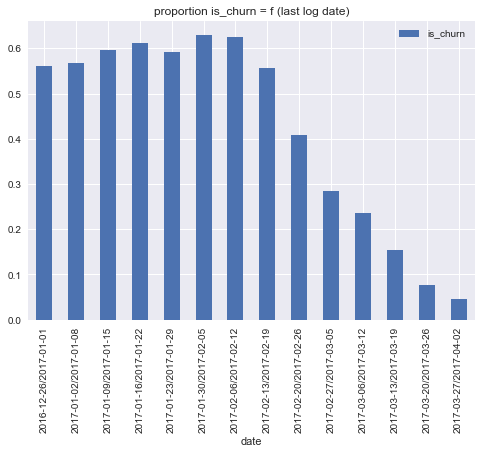

In [70]:
Date.plot.bar().set_title('proportion is_churn = f (last log date)')
plt.show()

### Number of connections : logs_count

In [94]:
logs_count=pd.DataFrame()
logs_count['is_churn']=train['is_churn'].astype(np.int8)
logs_count.head()
logs_count['logs_count']=pd.qcut(train['logs_count'],4)
#logs_count.groupby(['logs_count'])['is_churn'].mean().to_frame().style.background_gradient(cmap='summer_r')
logs_count.head()

,is_churn,logs_count
0,1,"(-0.001, 1.0]"
1,1,"(-0.001, 1.0]"
2,1,"(-0.001, 1.0]"
3,1,"(1.0, 13.0]"
4,1,"(13.0, 25.0]"


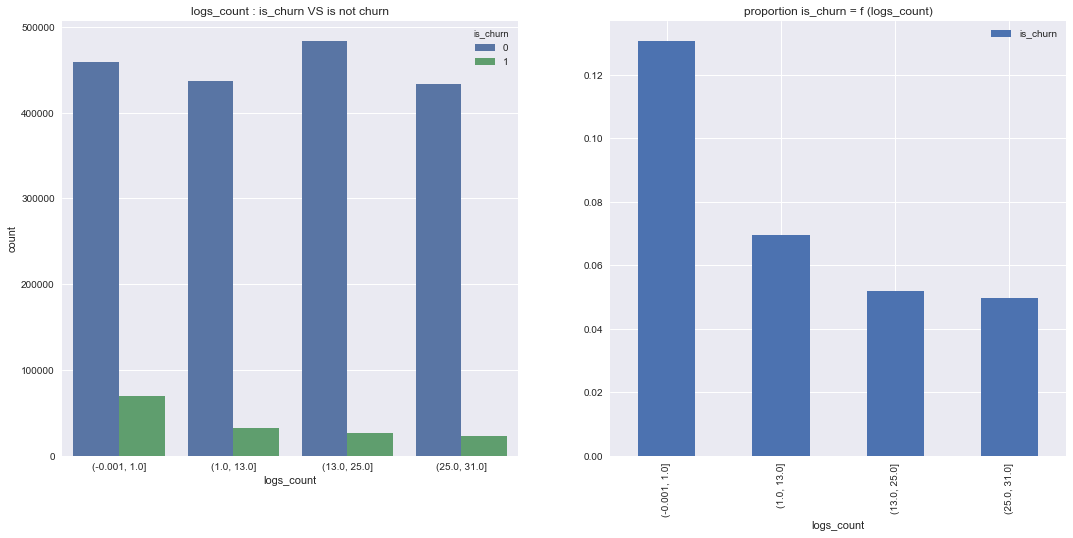

In [95]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.countplot('logs_count',hue='is_churn',data=logs_count,ax=ax[0])
ax[0].set_title('logs_count : is_churn VS is not churn')
logs_count[['logs_count','is_churn']].groupby(['logs_count']).mean().plot.bar(ax=ax[1])
ax[1].set_title('proportion is_churn = f (logs_count)')
plt.show()

##  II.3) Correlation between the important features

In [97]:
train_cor=pd.DataFrame()
train_cor['is_churn']=train['is_churn']
train_cor['transaction_date']=train['transaction_date']
train_cor['membership_expire_date']=train['membership_expire_date']
train_cor['trans_count']=train['trans_count']
train_cor['date']=train['date']
train_cor['logs_count']=train['logs_count']

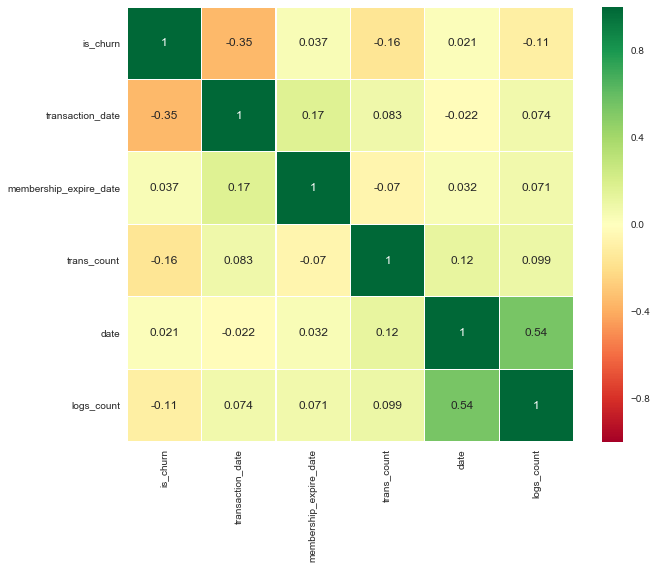

In [98]:
sns.heatmap(train_cor.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

# III) Feature engineering

## III.1) Adding of new features

### Adding of the discount feature

In [ ]:
train['discount']=train['plan_list_price']-train['actual_amount_paid']
test['discount']=test['plan_list_price']-train['actual_amount_paid']

### Adding of the autorenew/is_cancel related features

In [ ]:
train['autorenew_&_not_cancel'] = ((train.is_auto_renew == 1) == (train.is_cancel == 0)).astype(np.int8)
test['autorenew_&_not_cancel'] = ((test.is_auto_renew == 1) == (test.is_cancel == 0)).astype(np.int8)

train['notAutorenew_&_cancel'] = ((train.is_auto_renew == 0) == (train.is_cancel == 1)).astype(np.int8)
test['notAutorenew_&_cancel'] = ((test.is_auto_renew == 0) == (test.is_cancel == 1)).astype(np.int8)

## III.2) Filling missing values

### Filling the age feature properly

###### We decided to fill the age of the members that aren't correct by replacing their false value with the mean of its category (male, woman, nan)

In [121]:
train_age = train[train['bd'] >= 10]
train_age = train_age[train_age['bd'] <= 100]
age_mean=train_age['bd'].mean()
age_mean_false=train['bd'].mean()
print(age_mean)
print(age_mean_false)

31.7930781290815
31.7930781290815


In [120]:
## Assigning the NaN Values and the ridiculous values with the value of the mean ages
train.loc[(train['bd'].isnull())|(train['bd']<=10)|(train['bd']>=100),'bd']=30

## III.3) Removing useless features

### Removing Gender 

In [125]:
train.drop(['gender'],axis=1,inplace=True)

### Removing registered_via

In [126]:
train.drop(['registered_via'],axis=1,inplace=True)

### Removing is_cancel

In [131]:
train.drop(['is_cancel'],axis=1,inplace=True)

In [132]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963891 entries, 0 to 1963890
Data columns (total 25 columns):
msno                      object
is_churn                  int64
trans_count               int64
logs_count                float64
city                      float64
bd                        float64
registration_init_time    float64
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
date                      float64
num_25                    float64
num_50                    float64
num_75                    float64
num_985                   float64
num_100                   float64
num_unq                   float64
total_secs                float64
discount                  int64
autorenew_&_not_cancel    int8
notAutorenew_&_cancel     int8
dtypes: float64(12), int64(10), int8(2), object(1)
memory usage:

# IV) Predictive Modeling

## IV.1) K-folds

In [ ]:
#Set up folds
K=5
kf=sklearn.model_selection.KFold(n_splits=K, random_state=1, shuffle=True)
np.random.seed=0

y_valid_pred=0*train['is_churn']
pred_rdmfrst=0

## IV.2) Random Forrest

In [ ]:
clf = RandomForestClassifier(min_samples_split=40,max_leaf_nodes=15,n_estimators=50,max_depth=6,verbose=100)

for i, (train_index,test_index) in enumerate(kf.split(train)):
    
    y_train,y_valid=train['is_churn'].iloc[train_index].copy(), train['is_churn'].iloc[test_index]
    X_train, X_valid=train[cols].iloc[train_index,:].copy(),train[cols].iloc[test_index,:].copy()
    X_test=test.copy()
    print("\nFold" , i)
    
    fit_model=clf.fit(X_train,y_train)
    
    pred=fit_model.predict_proba(X_valid)[:,1]
    print("Log Loss =", sklearn.metrics.log_loss(y_valid,pred))
    y_valid_pred.iloc[test_index]=pred
    
    pred_rdmfrst +=fit_model.predict_proba(X_test[cols])[:,1]
    
    del X_test,X_train,X_valid,y_train
    
pred_rdmfrst /=K

## IV.3) XGBoost

In [12]:
def xgb_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'log_loss', metrics.log_loss(labels, preds)

fold = 1
for i in range(fold):
    params = {
        'eta': 0.025+i*pow(10,-3), #use 0.021
        'max_depth': 7,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train[cols], train['is_churn'], test_size=0.25, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 150,  watchlist, feval=xgb_score, maximize=False, verbose_eval=50, early_stopping_rounds=30) #use 1500
    if i != 0:
        pred_xgb += model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
    else:
        pred_xgb = model.predict(xgb.DMatrix(test[cols]), ntree_limit=model.best_ntree_limit)
pred_xgb /= fold
test['is_churn'] = pred_xgb.clip(0.+1e-15, 1-1e-15)
test[['msno','is_churn']].to_csv('submission.csv.gz', index=False, compression='gzip')

[0]	train-logloss:0.670777	valid-logloss:0.670783	train-log_loss:0.670777	valid-log_loss:0.670782
Multiple eval metrics have been passed: 'valid-log_loss' will be used for early stopping.

Will train until valid-log_loss hasn't improved in 30 rounds.
[50]	train-logloss:0.203375	valid-logloss:0.203504	train-log_loss:0.203375	valid-log_loss:0.203504
[100]	train-logloss:0.109073	valid-logloss:0.109255	train-log_loss:0.109073	valid-log_loss:0.109255
[149]	train-logloss:0.085666	valid-logloss:0.085938	train-log_loss:0.085666	valid-log_loss:0.085938


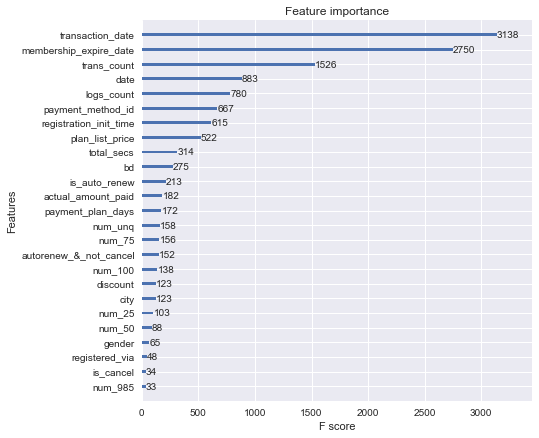

In [13]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model); plt.show()

## IV.4) Stacking & Creation of submission files

### Linear Stacking

In [ ]:
sub_lin=pd.DataFrame()
sub_lin['msno']=test['msno']
sub_lin['is_churn']=0.5*(pred_rdmfrst+pred_xgb)
sub_lin['is_churn']=sub_lin['is_churn'].clip(0.+1e-15,1-1e-15)
sub_lin.to_csv('sub_lin.csv.gz',index=False, compression='gzip')

### Log Stacking

In [ ]:
sub_log=pd.DataFrame()
sub_log['msno']=test['msno']

df_pred_rdmfrst=pd.DataFrame()
df_pred_rdmfrst['is_churn']=example_rdmfrst

df_pred_xgb=pd.DataFrame()
df_pred_xgb['is_churn']=pred_xgb

sub_log['is_churn']=np.exp(np.mean(
    [
    df_pred_xgb['is_churn'].apply(lambda x: np.log(x)),\
    df_pred_rdmfrst['is_churn'].apply(lambda x:np.log(x)),\
    ], axis=0))
sub_log['is_churn']=sub_log['is_churn'].clip(0.+1e-15,1-1e-15)

sub_log.to_csv('sub_logv2.csv.gz',index=False,compression='gzip')

### Random Forrest Submission

In [ ]:
sub=pd.DataFrame()
sub['msno']=test['msno']
sub['is_churn']=pred_rdmfrst.clip(0.+1e-15, 1-1e-15)
sub.to_csv('rdmforrest.csv.gz',index=False, compression='gzip')

### Xgboost Submission

In [ ]:
sub=pd.DataFrame()
sub['msno']=test['msno']
sub['is_churn']=pred_xgb.clip(0.+1e-15, 1-1e-15)
sub.to_csv('xgb.csv.gz',index=False, compression='gzip')